In [1]:
#Imports

import os
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Set Parameters
#1. Set parameters for data loading
excel_path = "Annotation_Zebrafish.xlsx"
images_folder = "Zebra_fish_data/test_data_withxml/test"
masks_folder = "Zebra_fish_data/test_data_withxml/masks_test"

#2. Set parameters for data processing
target_size=(640,640)	#Size of the images for training

#3. Train, Val, Test Split
train_size = 0.7
val_size = 0.1
test_size = 0.2
label_name = "Curved"

#4. Balance datasets
balance_train = True
balance_val = True
balance_test = False

#5 Transformer. Augmentation parameters
trans_rotation_range = 45
trans_width_shift_range = 0.2
trans_height_shift_range = 0.2
trans_zoom_range = 0.1
trans_horizontal_flip  = False
trans_fill_mode="nearest"

#6 Transformer. Training parameters
trans_learning_rate = 0.00008 # Define learing rate
trans_num_epochs = 1 # Define the number of epochs

#7 Transformer. Save parameters
trans_log_directory = f"Models/Transformer"
trans_model_name = "trans_model.pth"
trans_metrics_name = "trans_metrics.txt"

#5 CNN. Augmentation parameters
cnn_rotation_range = 45
cnn_width_shift_range = 0.2
cnn_height_shift_range = 0.2
cnn_zoom_range = 0.1
cnn_horizontal_flip  = False
cnn_fill_mode="nearest"

#6 CNN. Training parameters
cnn_learning_rate = 0.0001
cnn_loss = 'binary_crossentropy'
cnn_num_epochs = 2

#7 CNN. Save parameters
cnn_log_directory = "Models/CNN"
cnn_model_name = "vgg_16_model.h5"
cnn_metrics_name = "vgg_16_metrics.json"






In [3]:
#1) Match the images and masks to the exel data. 
# Create Df with the following columns: Image, Mask Path, Sample, Fish_Num, Edema, Curved, Masked Image

def process_fish_data(excel_path, images_folder, masks_folder):
    # Read the Excel file
    df = pd.read_excel(excel_path, dtype={'Sample': str, 'Fish_Num': int, 'Edema': str, 'Curved': str})

    # Convert Fish_Num to two-digit format (01, 02, ...)
    df['Fish_Num'] = df['Fish_Num'].apply(lambda x: f"{x:02d}")

    # Store results
    results = []

    for _, row in df.iterrows():
        sample = row['Sample']
        fish_num = row['Fish_Num']
        edema = row['Edema']
        curved = row['Curved']

        # Find the image
        image_pattern = os.path.join(images_folder, f"*pr_{sample}-*{fish_num}.jpg")
        image_files = glob.glob(image_pattern)

        # Find the mask
        mask_pattern = os.path.join(masks_folder, f"*pr_{sample}-*{fish_num}_mask.jpg")
        mask_files = glob.glob(mask_pattern)

        # Ensure exactly one match
        if len(image_files) != 1 or len(mask_files) != 1:
            print(f"Skipping Sample {sample}, Fish {fish_num}: Image or mask missing/multiple found.")
            continue

        image_path = image_files[0]
        mask_path = mask_files[0]

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Skipping {image_path} or {mask_path}: Unable to read file.")
            continue

        # Apply the mask: Everything outside the mask becomes black
        masked_image = cv2.bitwise_and(image, image, mask=mask)

        # Store in results list
        results.append([image_path, mask_path, sample, fish_num, edema, curved, masked_image])

    # Convert to DataFrame
    columns = ['Images', 'Masks', 'Sample', 'Fish_Num', 'Edema', 'Curved', 'Masked Images']
    result_df = pd.DataFrame(results, columns=columns)

    return result_df

df_result = process_fish_data(excel_path, images_folder, masks_folder)


Skipping Sample 20, Fish 02: Image or mask missing/multiple found.
Skipping Sample 21, Fish 05: Image or mask missing/multiple found.


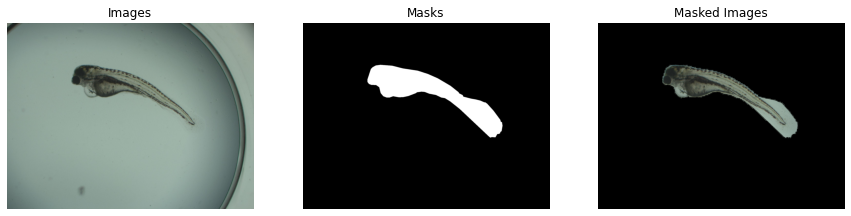

In [4]:
# display Image, Mask and Masked Image
def display_sample(df, index, Columns=['Images', 'Masks', 'Masked Images']):
    if index >= len(df):
        print("Index out of range.")
        return

    # Load images
    image = cv2.imread(df.iloc[index][Columns[0]])
    mask = cv2.imread(df.iloc[index][Columns[1]], cv2.IMREAD_GRAYSCALE)
    masked_image = df.iloc[index][Columns[2]]

    # Convert color format (OpenCV loads as BGR, Matplotlib expects RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title(Columns[0])
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(Columns[1])
    axes[2].imshow(masked_image)
    axes[2].set_title(Columns[2])

    # Remove axes ticks
    for ax in axes:
        ax.axis("off")

    plt.show()
    
display_sample(df_result, 40, Columns=['Images', 'Masks', 'Masked Images'])  

In [5]:
#2) Preprocess masked images.
def preprocess_masked_images(df, target_size):
    processed_images = []

    for i, row in df.iterrows():
        masked_image = row['Masked Images']

        # Step 1: Remove black-only rows and columns
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        coords = cv2.findNonZero(gray)  # Get non-black pixel coordinates

        if coords is None:  # In case the image is fully black (shouldn't happen)
            print(f"Skipping image {i}, it's fully black!")
            continue

        x, y, w, h = cv2.boundingRect(coords)  # Get bounding box
        cropped_image = masked_image[y:y+h, x:x+w]  # Crop to bounding box

        # Step 2: Pad to square size (symmetrically)
        height, width = cropped_image.shape[:2]
        max_dim = max(height, width)

        # Calculate symmetric padding
        pad_top = (max_dim - height) // 2
        pad_bottom = max_dim - height - pad_top
        pad_left = (max_dim - width) // 2
        pad_right = max_dim - width - pad_left

        padded_image = cv2.copyMakeBorder(
            cropped_image, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
        )

        # Step 3: Resize to target size
        resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_LINEAR)

        # Save processed image
        processed_images.append(resized_image)

    # Update the DataFrame
    df['Processed Masked Images'] = processed_images
    return df

df_result = preprocess_masked_images(df_result, target_size)

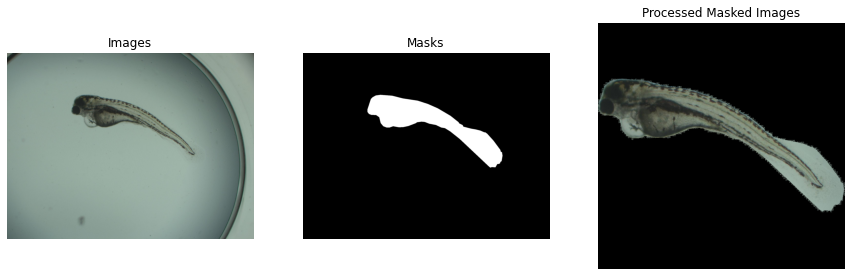

In [6]:
display_sample(df_result, 40, Columns=['Images', 'Masks', 'Processed Masked Images'])  


In [7]:
#Free up memory 
#Delete unnecessary columns of images and masks
df_result = df_result.drop(columns=["Images", "Masks", "Masked Images"])
#Delete Rows with NAW in the label column
df_result = df_result[df_result[label_name] != "NAW"]
# Convert label to integers
df_result["Curved"] = df_result["Curved"].astype(int) 


In [8]:
#3) Train, Val, Test Split saved in 3 new DataFrames

def split_data(df, train_size=70, val_size=20, test_size=10, label_name="Curved"):
    # Normalize percentages if they don’t sum to 100%
    total = train_size + val_size + test_size
    train_size, val_size, test_size = train_size / total, val_size / total, test_size / total

    # Shuffle data before splitting
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split into train and temp (val + test), stratified by label_name
    df_train, df_temp = train_test_split(df, test_size=(1 - train_size), random_state=42, stratify=df[label_name])

    # Split temp into val and test, also stratified
    df_val, df_test = train_test_split(df_temp, test_size=(test_size / (test_size + val_size)), 
                                       random_state=42, stratify=df_temp[label_name])

    return df_train, df_val, df_test

# Example usage
df_train, df_val, df_test = split_data(df_result, train_size, val_size, test_size, label_name)


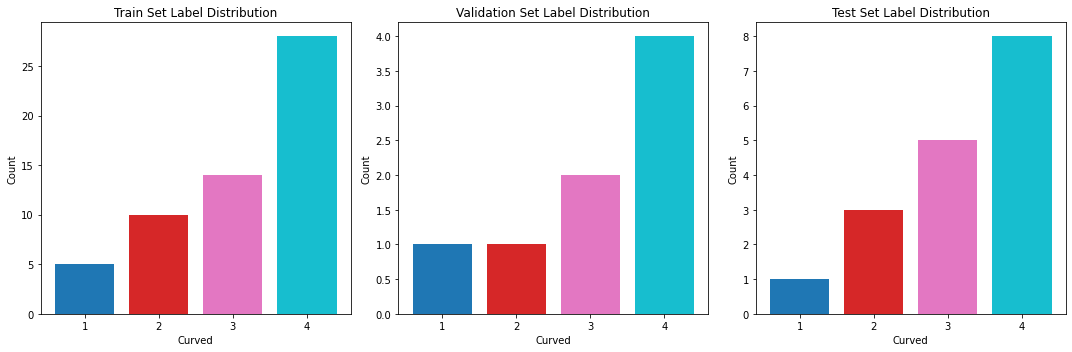

In [9]:
#Display label distribution

def plot_label_distribution(df_train, df_val, df_test, label_name):
    # Get all unique classes across all sets and sort them numerically
    unique_classes = sorted(set(df_train[label_name].unique()) | 
                            set(df_val[label_name].unique()) | 
                            set(df_test[label_name].unique()))
    
    # Generate a color palette based on the number of classes
    colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Adjust colormap if more than 10 classes
    
    # Create a dictionary for consistent color mapping
    color_map = {class_label: colors(i) for i, class_label in enumerate(unique_classes)}

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, df, title in zip(axes, [df_train, df_val, df_test], ["Train", "Validation", "Test"]):
        label_counts = df[label_name].value_counts()

        # Ensure labels are sorted numerically
        sorted_labels = sorted(label_counts.index)

        # Plot the bars using the consistent colors
        ax.bar(sorted_labels, label_counts[sorted_labels].values, 
               color=[color_map[label] for label in sorted_labels])

        ax.set_title(f"{title} Set Label Distribution")
        ax.set_xlabel(label_name)
        ax.set_ylabel("Count")
        ax.set_xticks(sorted_labels)

    plt.tight_layout()
    plt.show()



# Example usage
plot_label_distribution(df_train, df_val, df_test, label_name)

In [10]:
#4) Balance the dataframes

#Augmentation functions
def apply_augmentation(image, augmentation_type):
    if augmentation_type == 'horizontal_flip':
        return cv2.flip(image, 1)
    elif augmentation_type == 'vertical_flip':
        return cv2.flip(image, 0)
    elif augmentation_type == 'both_flip':
        return cv2.flip(image, -1)
    elif augmentation_type == 'zoom_out':
        height, width = image.shape[:2]
        zoom_factor = 0.8  # 20% zoom out
        
        # Resize the image to 80% of its original size (zoom-out)
        resized_image = cv2.resize(image, (int(width * zoom_factor), int(height * zoom_factor)))
        
        # Create a black image of the original size
        padded_image = np.zeros((height, width, 3), dtype=np.uint8)
        
        # Calculate the padding size (difference between original and resized dimensions)
        top = (height - resized_image.shape[0]) // 2
        bottom = height - resized_image.shape[0] - top
        left = (width - resized_image.shape[1]) // 2
        right = width - resized_image.shape[1] - left
        
        # Place the resized image into the black canvas with padding
        padded_image[top:top+resized_image.shape[0], left:left+resized_image.shape[1]] = resized_image
        
        return padded_image
    return image

#Balance the dataframes by counting the most frequent class and augmenting the other classes
def balance_dataframe(df_frame, label_name, augmentations=['horizontal_flip', 'vertical_flip', 'both_flip', 'zoom_out']):
    # 1. Find the most represented class (most frequent class)
    most_frequent_class = df_frame[label_name].mode()[0]
    largest_class_size = (df_frame[label_name] == most_frequent_class).sum()

    # 2. Create a list to store augmented data
    augmented_rows = []

    # 3. Iterate over all the other classes
    for current_class in df_frame[label_name].unique():
        if current_class == most_frequent_class:
            continue  # Skip the most frequent class

        # Calculate the imbalance factor
        current_class_size = (df_frame[label_name] == current_class).sum()
        imbalance_factor = largest_class_size / current_class_size

        # Find the closest augmentation set to apply
        num_augmentations = min(5, round(imbalance_factor)) - 1  # Max 4 augmentations per image

        # Get the rows for the current class
        class_df = df_frame[df_frame[label_name] == current_class]

        # 4. Apply augmentations to each image in the current class
        for _, row in class_df.iterrows():
            original_image = row['Processed Masked Images']  # Image path or image itself

            for i in range(num_augmentations):
                augmented_image = apply_augmentation(original_image, augmentations[i])

                # Copy the row and replace the augmented image
                augmented_row = row.copy()
                augmented_row['Processed Masked Images'] = augmented_image
                augmented_rows.append(augmented_row)

    # 5. Combine the original and augmented data
    augmented_df = pd.DataFrame(augmented_rows)
    balanced_df = pd.concat([df_frame, augmented_df], ignore_index=True)

    return balanced_df

#Toggle to balance train, val and test dataframes
if balance_train==True:
    df_train = balance_dataframe(df_train, label_name)
if balance_val==True:
    df_val = balance_dataframe(df_val, label_name)
if balance_test==True:
    df_test = balance_dataframe(df_test, label_name)    


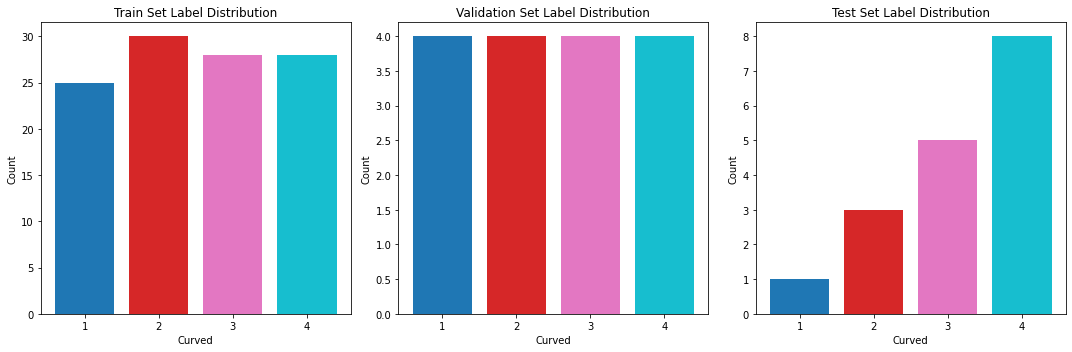

In [11]:
#Display Label Distribution after balancing
plot_label_distribution(df_train, df_val, df_test, label_name)

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import timm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

seed = 111

# Configure the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=trans_rotation_range,
    width_shift_range=trans_width_shift_range,
    height_shift_range=trans_height_shift_range,
    zoom_range=trans_zoom_range,
    horizontal_flip=trans_horizontal_flip,
    fill_mode=trans_fill_mode,
)

# Function to apply data augmentation to a batch
def apply_data_augmentation(batch_data):
    batch_data_array = np.array(batch_data)
    augmented_batch_data = []
    for image in batch_data_array:
        augmented_image = train_datagen.random_transform(image)
        augmented_batch_data.append(augmented_image)
    return augmented_batch_data

# Feature extractor function (you might want to adjust this based on the specific model you are using)
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/deit-small-distilled-patch16-224")

#Create data and Labels from the dataframes
def create_data_and_labels(df_frame, label_name):
    data = []
    labels = []

    for _, row in df_frame.iterrows():
        image = row['Processed Masked Images']
        label = row[label_name]

        data.append(image)
        labels.append(int(label))  # Convert label to integer

    return data, labels

train_data, train_labels = create_data_and_labels(df_train, label_name)
val_data, val_labels = create_data_and_labels(df_val, label_name)
test_data, test_labels = create_data_and_labels(df_test, label_name)


# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(list(zip(train_data, train_labels)), batch_size=25, shuffle=True)
val_loader = DataLoader(list(zip(val_data, val_labels)), batch_size=25, shuffle=True)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size=25, shuffle=False)

# Load the pre-trained DeiT model with 224x224 resolution
trans_model = timm.create_model('deit_small_distilled_patch16_224', pretrained=True)

# Define the optimizer and loss function
optimizer = Adam(trans_model.parameters(), lr=trans_learning_rate)
criterion = CrossEntropyLoss()

# Lists to track metrics
training_loss_list = []
training_acc_list = []
val_acc_list = []

c:\Users\9andy\anaconda3\lib\site-packages\transformers\models\deit\feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [15]:
# Training loop
for epoch in range(trans_num_epochs):
    print(f'Epoch {epoch + 1}/{trans_num_epochs}')  # Print the current epoch number
    
    # Initialize metrics for training
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Training phase
    trans_model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs = apply_data_augmentation(inputs)  # Apply data augmentation to the input batch
        optimizer.zero_grad()  # Reset gradients from the previous step
        
        # Preprocess inputs and perform forward pass
        batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
        pixel_values = batch['pixel_values']  # Extract the tensor for the model input

        outputs = trans_model(pixel_values)
        
        # Calculate loss and perform backward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights
        
        # Accumulate loss and accuracy metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    
    # Store training metrics for later analysis
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)

    # Validation phase
    trans_model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
            pixel_values = batch['pixel_values']
            outputs = trans_model(pixel_values)
            
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
    
    # Calculate validation accuracy for the epoch
    val_accuracy = val_correct_predictions / val_total_predictions

    val_acc_list.append(val_accuracy)


# Log metrics and test labels

os.makedirs(trans_log_directory, exist_ok=True)

# Save the model at the end of training (after the final epoch)
final_model_path = os.path.join(trans_log_directory, trans_model_name)
torch.save(trans_model.state_dict(), final_model_path)
print(f'Model saved to {final_model_path}')

# Save metrics
metrics_path = os.path.join(trans_log_directory, trans_metrics_name)
with open(metrics_path, 'w') as f:
    f.write('Training Loss List:\n')
    f.write(str(training_loss_list) + '\n\n')
    f.write('Training Accuracy List:\n')
    f.write(str(training_acc_list) + '\n\n')
    f.write('Validation Accuracy List:\n')
    f.write(str(val_acc_list) + '\n\n')
    
    
#compute test accuracy
trans_model.eval()  # Set the model to evaluation mode
test_correct_predictions = 0
test_total_predictions = 0

with torch.no_grad():  # Disable gradient computation for validation
    for inputs, labels in test_loader:
        batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
        pixel_values = batch['pixel_values']
        outputs = trans_model(pixel_values)
        
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_predictions += labels.size(0)

# Calculate validation accuracy for the epoch
test_accuracy = test_correct_predictions / test_total_predictions

print(f'Test Accuracy: {test_accuracy:.2%}')

Epoch 1/1
Model saved to Models/Transformer\trans_model.pth
Test Accuracy: 52.94%


In [14]:
import os
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Data augmentation function
def preprocess_function(image):
    # Adjust contrast of the image
    image = tf.image.adjust_contrast(image, 1.2)
    return image

train_datagen = ImageDataGenerator(
    rotation_range=cnn_rotation_range,
    width_shift_range=cnn_width_shift_range,
    height_shift_range=cnn_height_shift_range,
    zoom_range=cnn_zoom_range,
    horizontal_flip=cnn_horizontal_flip,
    fill_mode=cnn_fill_mode,
    preprocessing_function=preprocess_function  # Custom preprocessing function
)

# Load the pre-trained VGG16 model
# Include only convolutional base (no fully connected layers) and use the specified input shape
input_shape = (target_size[0], target_size[1], 3)  # Specify the input shape
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the pre-trained model
for layer in vgg16.layers:
    layer.trainable = False


# Add custom classification head
x = Flatten()(vgg16.output)  # Flatten the feature map into a 1D vector
x = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(x)  # Fully connected layer with L1 regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Define the complete model
model = Model(inputs=vgg16.input, outputs=predictions)

# Print a summary of the model
model.summary()

# Normalize the data and convert to NumPy arrays
def normalize_images(data):
    # Check if data contains np.arrays, if yes, directly normalize them
    if isinstance(data[0], np.ndarray):
        return np.array(data, dtype=np.float32) / 255.0
    else:
        return np.array([np.array(image) for image in data], dtype=np.float32) / 255.0

X_train = normalize_images(train_data)
X_val = normalize_images(val_data)
X_test = normalize_images(test_data)


# Preprocess input data for VGG16 (standardize based on ImageNet)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
#X_test = preprocess_input(X_test)

# Convert labels to NumPy arrays
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# Verify the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create a training data generator with data augmentation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


# Compile the model
model.compile(
    optimizer=Adam(learning_rate=cnn_learning_rate),  # Optimizer with specified learning rate
    loss=cnn_loss,  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']  # Track accuracy during training
)

# Train the model
history = model.fit(
    train_generator,  # Use the augmented data generator for training
    epochs=cnn_num_epochs,  # Train for 45 epochs (adjust as needed)
    validation_data=(X_val, y_val)  # Use the validation set for evaluation
)

# Save metrics after trainingcnn_log_directory
os.makedirs(cnn_log_directory, exist_ok=True)

metrics = {
    "train_loss": history.history['loss'],  # Training loss for each epoch
    "train_accuracy": history.history['accuracy'],  # Training accuracy for each epoch
    "val_accuracy": history.history['val_accuracy'],  # Validation accuracy for each epoch
}

metrics_path = os.path.join(cnn_log_directory, cnn_metrics_name)
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"Metrics saved to {metrics_path}")

# Save the trained model
model_save_path = os.path.join(cnn_log_directory, cnn_model_name)
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 320, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 160, 160, 128)     0     

In [ ]:
#8 Display the results

#Add confusion matrix
#add traing plots fomr metrix
#add test accuracy